In [1]:
#https://hf-mirror.com/learn/diffusion-course/unit2/2
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from datasets import load_dataset
from diffusers import DDIMScheduler, DDPMPipeline
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm

/home/jiuxia/libs/python/anaconda3/envs/comfyui/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
image_pipe = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256")
image_pipe.to(device)

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]An error occurred while trying to fetch /home/jiuxia/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d: Error no file named diffusion_pytorch_model.safetensors found in directory /home/jiuxia/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Loading pipeline components...: 100%|██████████| 2/2 [00:00<00:00,  8.78it/s]


DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.32.2",
  "_name_or_path": "google/ddpm-celebahq-256",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

100%|██████████| 1000/1000 [00:28<00:00, 35.42it/s]


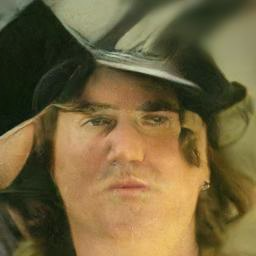

In [4]:
images = image_pipe().images
images[0]

In [5]:
scheduler = DDIMScheduler.from_pretrained("google/ddpm-celebahq-256")
scheduler.set_timesteps(num_inference_steps=40)

In [6]:
scheduler.timesteps

tensor([975, 950, 925, 900, 875, 850, 825, 800, 775, 750, 725, 700, 675, 650,
        625, 600, 575, 550, 525, 500, 475, 450, 425, 400, 375, 350, 325, 300,
        275, 250, 225, 200, 175, 150, 125, 100,  75,  50,  25,   0])

0it [00:00, ?it/s]

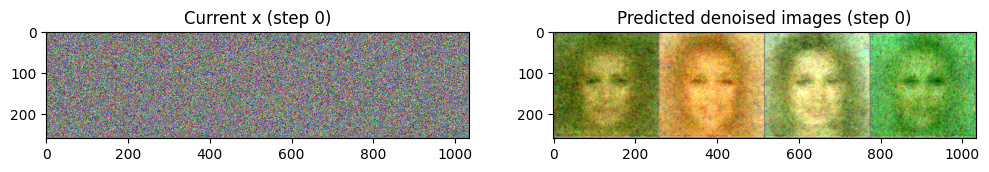

10it [00:01,  9.07it/s]

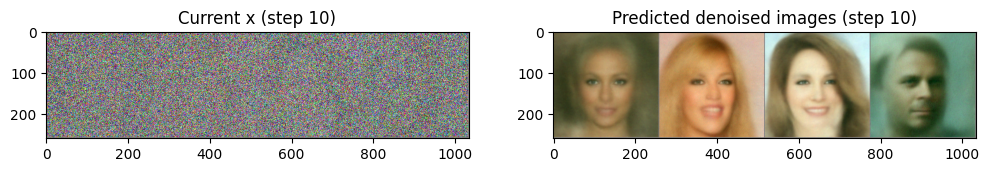

20it [00:02,  8.63it/s]

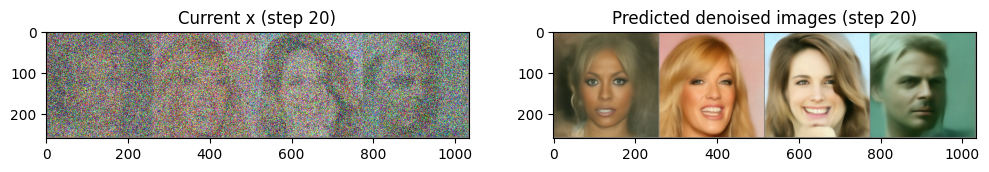

30it [00:03,  8.47it/s]

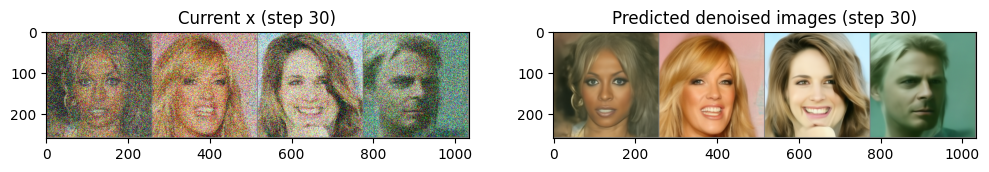

39it [00:04,  8.49it/s]

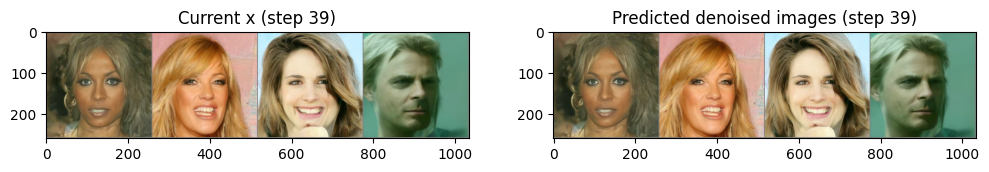

40it [00:05,  7.93it/s]


In [10]:
x = torch.randn(4, 3, 256, 256).to(device)

for i, t in tqdm(enumerate(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x, t)
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]
    scheduler_output = scheduler.step(noise_pred, t, x)
    x = scheduler_output.prev_sample
    pred_x0 = scheduler_output.pred_original_sample

    # Occasionally display both x and the predicted denoised images
    if i % 10 == 0 or i == len(scheduler.timesteps) - 1:
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))

        grid = torchvision.utils.make_grid(x, nrow=4).permute(1, 2, 0)
        axs[0].imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5)
        axs[0].set_title(f"Current x (step {i})")

        pred_x0 = scheduler_output.pred_original_sample  # Not available for all schedulers
        grid = torchvision.utils.make_grid(pred_x0, nrow=4).permute(1, 2, 0)
        axs[1].imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5)
        axs[1].set_title(f"Predicted denoised images (step {i})")
        plt.show()

## Finetune

Repo card metadata block was not found. Setting CardData to empty.


Previewing batch:


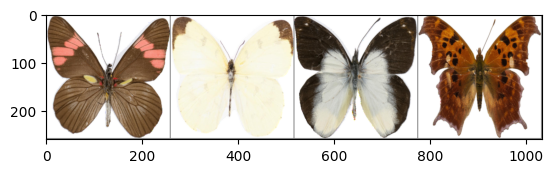

In [11]:
# @markdown load and prepare a dataset:
# Not on Colab? Comments with #@ enable UI tweaks like headings or user inputs
# but can safely be ignored if you're working on a different platform.

dataset_name = "huggan/smithsonian_butterflies_subset"  # @param
dataset = load_dataset(dataset_name, split="train")
image_size = 256  # @param
batch_size = 4  # @param
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)


def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}


dataset.set_transform(transform)

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

print("Previewing batch:")
batch = next(iter(train_dataloader))
grid = torchvision.utils.make_grid(batch["images"], nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5)

/home/jiuxia/libs/python/anaconda3/envs/comfyui/lib/python3.12/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 0 average loss: 0.016226792909466894
Epoch 1 average loss: 0.0134559664898552


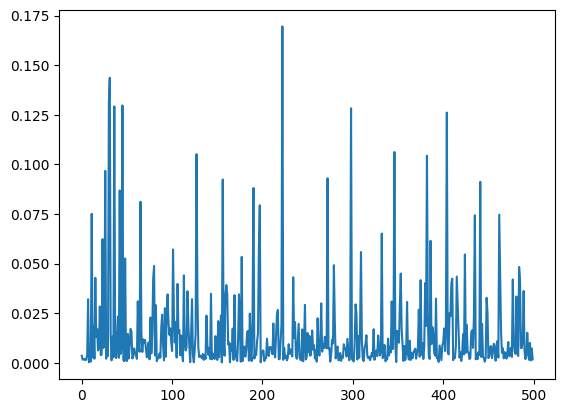

In [13]:
num_epochs = 2
lr = 1e-5
grad_accumulation_steps = 2

optimizer = torch.optim.AdamW(image_pipe.unet.parameters(), lr=lr)
losses = []

for epoch in range(num_epochs):
    for step, batch in enumerate(train_dataloader):
        clean_image = batch["images"].to(device)
        noise = torch.randn(clean_image.shape).to(device)
        bs = clean_image.shape[0]

        timesteps = torch.randint(0, image_pipe.scheduler.num_train_timesteps, (bs,), device=device).long()

        noisy_images = image_pipe.scheduler.add_noise(clean_image, noise, timesteps)
        noise_pred = image_pipe.unet(noisy_images, timesteps, return_dict=False)[0]
        loss = F.mse_loss(noise_pred, noise)
        losses.append(loss.item())
        loss.backward()
        
        if (step + 1) % grad_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
    print(f"Epoch {epoch} average loss: {sum(losses[-len(train_dataloader):])/len(train_dataloader)}")

# Plot the loss curve:
plt.plot(losses)


40it [00:09,  4.20it/s]


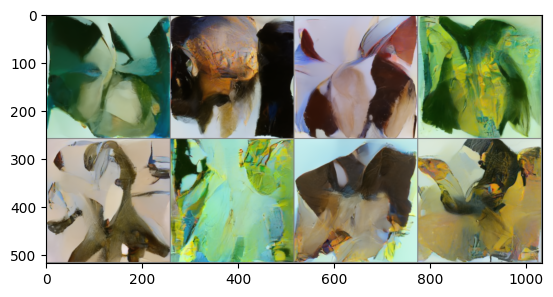

In [14]:
# @markdown Generate and plot some images:
x = torch.randn(8, 3, 256, 256).to(device)  # Batch of 8
for i, t in tqdm(enumerate(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x, t)
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]
    x = scheduler.step(noise_pred, t, x).prev_sample
grid = torchvision.utils.make_grid(x, nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5)

In [15]:
image_pipe.save_pretrained("bullter-fly-fine")

## Guidance

使用loss对无条件模型进行引导。不需要重新训练模型，增加一个颜色loss，通过梯度对原始的x产生影响。
此处可以理解为classifier guidance
x0 是模型的预测，此处是噪声。
prev_sample是xt-1,用于进行下一个step
pred_original_sample是当前阶段的x_0

In [20]:

def color_loss(images, target_color=(0.1, 0.9, 0.5)):
    target = torch.tensor(target_color).to(images.device)*2-1
    target = target[None, :, None, None]
    error = torch.abs(images - target).mean()
    return error

0 loss: 21.590147018432617
10 loss: 11.427874565124512
20 loss: 11.195464134216309
30 loss: 11.428336143493652


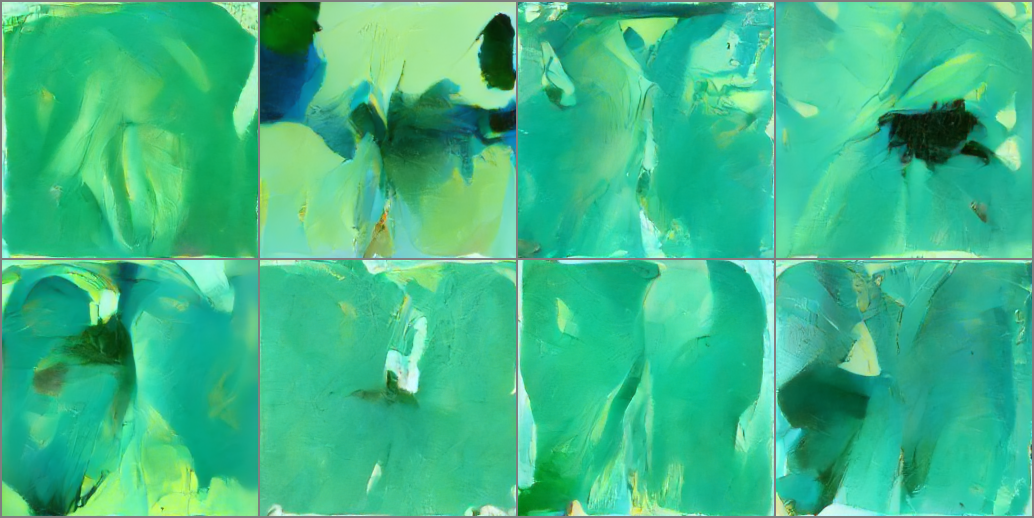

In [21]:
# variant 1
guidance_loss_scale = 40

x = torch.randn(8, 3, 256, 256).to(device)
for i, t in enumerate(scheduler.timesteps):
    model_input = scheduler.scale_model_input(x, t)
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]

    #set x requires_grad true
    x = x.detach().requires_grad_()
    x0 = scheduler.step(noise_pred, t, x).pred_original_sample
    loss = color_loss(x0)*guidance_loss_scale
    if i%10==0:
        print(i, "loss:", loss.item())
    cond_grad = - torch.autograd.grad(loss, x)[0]
    x = x.detach() + cond_grad
    x = scheduler.step(noise_pred, t, x).prev_sample

grid = torchvision.utils.make_grid(x, nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1)*0.5+0.5
Image.fromarray(np.array(im*255).astype(np.uint8))


0 loss: 20.486164093017578
10 loss: 11.12729263305664
20 loss: 10.717964172363281
30 loss: 10.95435619354248


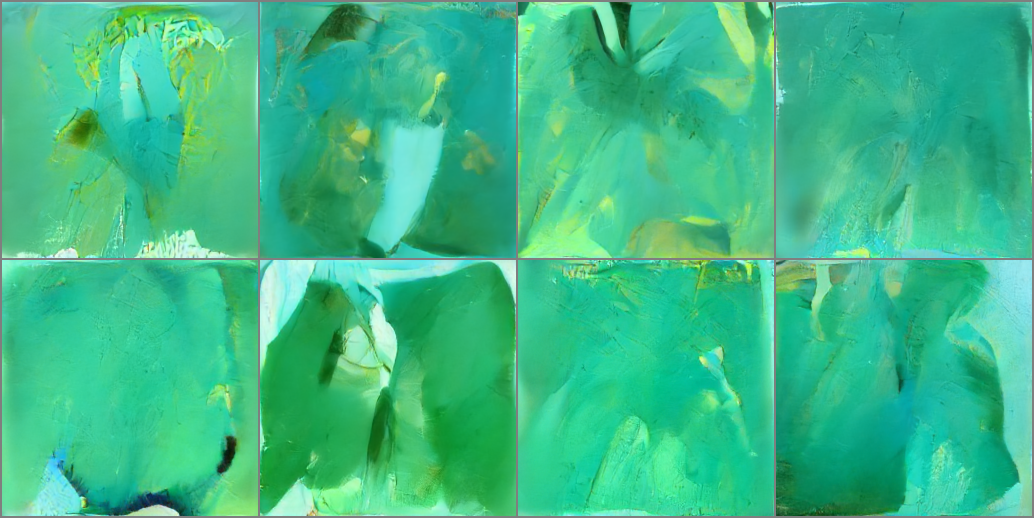

In [25]:
# Variant 2: setting x.requires_grad before calculating the model predictions
guidance_loss_scale = 40

x = torch.randn(8, 3, 256, 256).to(device)
for i, t in enumerate(scheduler.timesteps):
    #set x requires_grad true
    x = x.detach().requires_grad_()
    model_input = scheduler.scale_model_input(x, t)
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]

    x0 = scheduler.step(noise_pred, t, x).pred_original_sample
    loss = color_loss(x0)*guidance_loss_scale
    if i%10==0:
        print(i, "loss:", loss.item())
    cond_grad = - torch.autograd.grad(loss, x)[0]
    x = x.detach() + cond_grad
    x = scheduler.step(noise_pred, t, x).prev_sample

grid = torchvision.utils.make_grid(x, nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1)*0.5+0.5
Image.fromarray(np.array(im*255).astype(np.uint8))


Text(0.5, 1.0, 'Possible guidance scaling schedules')

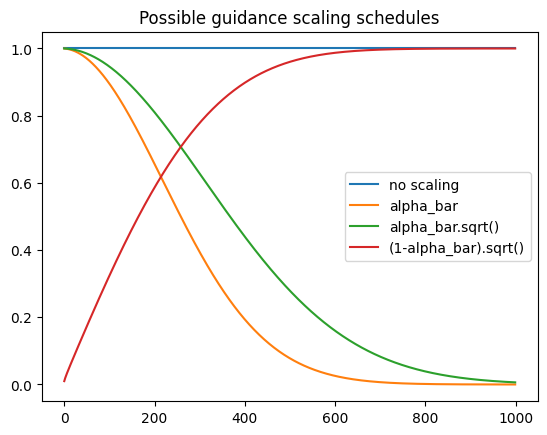

In [29]:
plt.plot([1 for a in scheduler.alphas_cumprod], label="no scaling")
plt.plot([a.cpu().numpy() for a in scheduler.alphas_cumprod], label="alpha_bar")
plt.plot([a.sqrt().cpu().numpy() for a in scheduler.alphas_cumprod], label="alpha_bar.sqrt()")
plt.plot([(1 - a).sqrt().cpu().numpy() for a in scheduler.alphas_cumprod], label="(1-alpha_bar).sqrt()")
plt.legend()
plt.title("Possible guidance scaling schedules")

In [ ]:
# @markdown load a CLIP model and define the loss function
import open_clip

clip_model, _, preprocess = open_clip.create_model_and_transforms("ViT-B-32", pretrained="openai")
clip_model.to(device)

# Transforms to resize and augment an image + normalize to match CLIP's training data
tfms = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomResizedCrop(224),  # Random CROP each time
        torchvision.transforms.RandomAffine(5),  # One possible random augmentation: skews the image
        torchvision.transforms.RandomHorizontalFlip(),  # You can add additional augmentations if you like
        torchvision.transforms.Normalize(
            mean=(0.48145466, 0.4578275, 0.40821073),
            std=(0.26862954, 0.26130258, 0.27577711),
        ),
    ]
)


# And define a loss function that takes an image, embeds it and compares with
# the text features of the prompt
def clip_loss(image, text_features):
    image_features = clip_model.encode_image(tfms(image))  # Note: applies the above transforms
    input_normed = torch.nn.functional.normalize(image_features.unsqueeze(1), dim=2)
    embed_normed = torch.nn.functional.normalize(text_features.unsqueeze(0), dim=2)
    dists = input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2)  # Squared Great Circle Distance
    return dists.mean()

In [ ]:
# @markdown applying guidance using CLIP

prompt = "Red Rose (still life), red flower painting"  # @param

# Explore changing this
guidance_scale = 8  # @param
n_cuts = 4  # @param

# More steps -> more time for the guidance to have an effect
scheduler.set_timesteps(50)

# We embed a prompt with CLIP as our target
text = open_clip.tokenize([prompt]).to(device)
with torch.no_grad(), torch.cuda.amp.autocast():
    text_features = clip_model.encode_text(text)


x = torch.randn(4, 3, 256, 256).to(device)  # RAM usage is high, you may want only 1 image at a time

for i, t in tqdm(enumerate(scheduler.timesteps)):

    model_input = scheduler.scale_model_input(x, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]

    cond_grad = 0

    for cut in range(n_cuts):

        # Set requires grad on x
        x = x.detach().requires_grad_()

        # Get the predicted x0:
        x0 = scheduler.step(noise_pred, t, x).pred_original_sample

        # Calculate loss
        loss = clip_loss(x0, text_features) * guidance_scale

        # Get gradient (scale by n_cuts since we want the average)
        cond_grad -= torch.autograd.grad(loss, x)[0] / n_cuts

    if i % 25 == 0:
        print("Step:", i, ", Guidance loss:", loss.item())

    # Modify x based on this gradient
    alpha_bar = scheduler.alphas_cumprod[i]
    x = x.detach() + cond_grad * alpha_bar.sqrt()  # Note the additional scaling factor here!

    # Now step with scheduler
    x = scheduler.step(noise_pred, t, x).prev_sample


grid = torchvision.utils.make_grid(x.detach(), nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
Image.fromarray(np.array(im * 255).astype(np.uint8))